## Sampling a multi-dimensional Gaussian

In [8]:
import numpy as np

- Define a function to return density of Gaussian for different parameters 
- emcee requires logarithm of probaility

In [9]:
def log_prob(x, mu, cov):
    diff  = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

- First argument of probability function should be the position of a single N dimensional array
- Next set values for the 'hyperparameters', here we have 5 dimensions

In [36]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)
cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim,ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)
print(cov.shape)

(5, 5)


- We will use 32 walkers
- Need to guess a starting point for each walker, which will be in 5D space
- So the starting points will be defined in a 32x5 array

In [41]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

- Main interface for emcee is the ENSEMBLE SAMPLER

In [12]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

- By setting up the ensemble sampler with args we are saying the function should be called as below 

In [13]:
log_prob(p0[0], means, cov)

-2.596094589085444

- It's a good idea to run some 'burn-in' steps to let the walkers explore the parameter space
- We'll run 100 burn in steps

In [14]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

- We save the positions of walkers after 100 steps and reset sampler
- Then do the production run starting from the positions the walkers got to after the burn in steps

In [15]:
sampler.run_mcmc(state, 10000);

- The samples can be accessed using EnsembleSampler.get_chain()
- This gives the parameter values for each walker at each step in a (steps, walkers, dims) array
- Cna plot a histogram of the samnples to get an estimate of the density being sampled

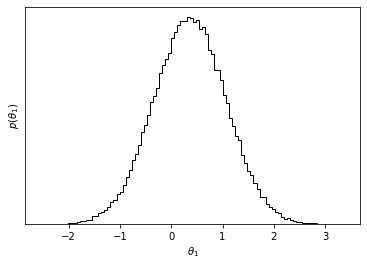

In [16]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:,0], 100, color='k', histtype='step')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$p(\theta_1)$')
plt.gca().set_yticks([]);

- to test if the sampling went well can look at the MEAN ACCEPTANCE FRACTION
- and the autocorrelation

In [17]:
print('Mean acceptance fraction: {0:.3f}'.format(np.mean(sampler.acceptance_fraction)))
print('Mean autocorrelation time: {0:.3f}'.format(np.mean(sampler.get_autocorr_time())))

Mean acceptance fraction: 0.552
Mean autocorrelation time: 57.112


## Fitting a model to data

- For a new problem, the first step is to write the LIKELIHOOD FUNCTION (probaility of a dataset given the model parameters)
- In this case we consider a linear model where the quoted uncertainties are underestimated by a constant amount

Text(0, 0.5, 'y')

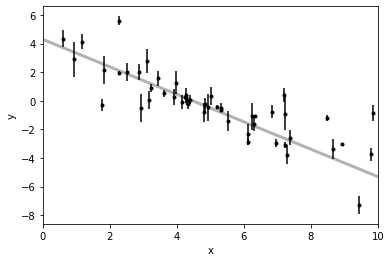

In [18]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the 'true' parameters
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate synthetic data from the model
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.randn(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, 'k', alpha=0.3, lw=3)
plt.xlim(0,10)
plt.xlabel('x')
plt.ylabel('y')

- The thick gray line represents the 'true' model 
- The uncertainties are obviously underestimated because most don't cross the true model
- The standard way to fit this data would be linear least squares fitting

Least-squares estimates:
m = -0.707 ± 0.011
b = 3.216 ± 0.056


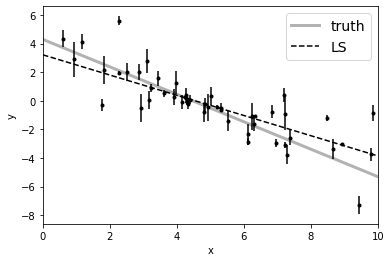

In [19]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

## Maximum likelihood estimation
- We need to write down the likelihood function and numerically optimise it
- In this case the likelihood function is a Gaussian with variance underestimated by an amount f

In [20]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

- to find the numerical optimum can use scipy.optimize
- this module minimizes things and we want maximum likelihood so we minimize the negative likelihood

Maximum likelihood estimates:
m = -0.846
b = 3.781
f = 0.594


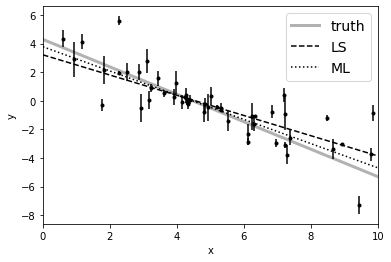

In [21]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x,y,yerr))
m_ml, b_ml, log_f_ml = soln.x

print('Maximum likelihood estimates:')
print('m = {0:.3f}'.format(m_ml))
print('b = {0:.3f}'.format(b_ml))
print('f = {0:.3f}'.format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

- How do we estimate the uncertainties on m and b? Use MCMC
- We need PRIORS, previous knowledge about the parameters. This is becuase we want to draw from a probaility distribution of our parameters, we can't draw samples from a likelihood function becuase it is a probability distribution OVER DATASETS, so you can draw datasets but not parameter samples

In [22]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

- Combining this with the log_likelihood function, the full log_probability function is:

In [23]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

- Start by initialising walkers in a small Gaussian ball around the max likelihood result
- Then run 5000 steps

In [38]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:10<00:00, 495.83it/s]


In [45]:
print(soln.x)

[-0.84629854  3.78120748 -0.52068572]


In [44]:
log_likelihood(pos[0], x, y, yerr)

-18.35941233473744

- The figure below shows the positions of each walker as a function of the steps

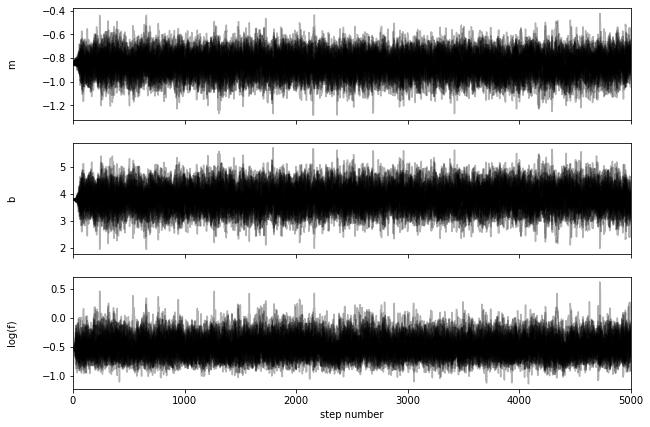

In [25]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [26]:
tau = sampler.get_autocorr_time()
print(tau)

[38.2664106  39.39415881 39.51229664]


- This suggests the samples are burnt in after about 40 steps, or they have 'forgotten' where they started
- We can throw away the burn in steps + a few, for example, we can discard the first 100 steps and then thin by half the autocorrelation time, then flatten the chain

In [27]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


## Results
- The corner plot shows all the projections of the distribution of your parameters
- It shows all the covariance between parameters, the diagonal is the distribution for each parameter independatantly and the off diagonals two dimensional distributions of two parameters

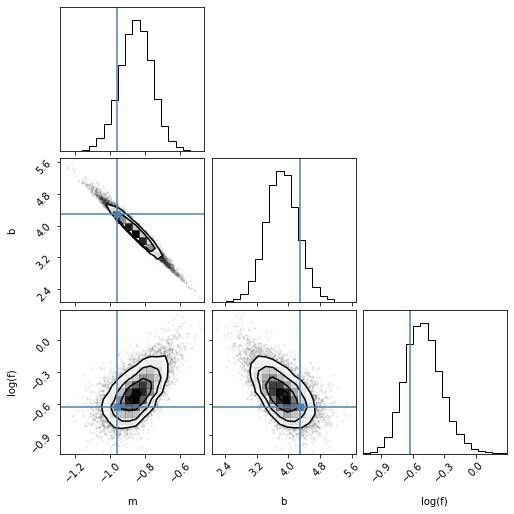

In [28]:
import corner

fig = corner.corner(
        flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

- Can also project results into the space of the observed data
- Do this by choosing a few samples from the chain and plotting them on top of data points

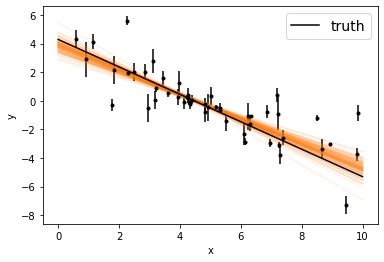

In [29]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), 'C1', alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0)
plt.plot(x0, m_true * x0 + b_true, 'k', label='truth')
plt.legend(fontsize=14)
plt.xlabel('x')
plt.ylabel('y');

- Can quote uncertainties based on the 16th, 50th and 84th percentiles of the samples in the marginalized distributions

In [30]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q  = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>